In [9]:
## Initialisation
import pandas as pd
import geopandas
import numpy as np
from lmfit import Model, models
import matplotlib
import matplotlib.pyplot as plt
from covid.grabbers import grab_wbdata, grab_JHU
from covid.utils import print_wb_indicators, print_wb_sources, find_date_of_nth_label
from covid.constants import POP_DF_RENAMED_COUNTRIES 
# set up the wbdata indicator (just build up the dict if you want more than one)
indicators = {'VA.EST': 'Voice and Accountability', 'GE.EST': 'Government Effectiveness'}

# We use two dataframes. One for for storing zone-wide wide and one for timeseries stuff
zone_df = pd.DataFrame(columns=['zone'])
ts_df = pd.DataFrame(columns=['zone', 'date'])


In [10]:
# Grab data - wbdata
# grab indicators and load into data frame
wb_df = grab_wbdata(indicators)

gov_df = wb_df.groupby(level='country').tail(5).groupby(level='country').mean()
gov_df.index.name = 'zone'

# Merge into zone_df
zone_df = pd.merge(zone_df, gov_df, on='zone', how='right')

del indicators
del gov_df
del wb_df
zone_df

,zone,Voice and Accountability,Government Effectiveness
0,Afghanistan,-1.718050,-1.838644
1,Albania,-0.251730,-0.629331
2,Algeria,-1.128412,-0.818300
3,American Samoa,NaN,NaN
4,Andorra,1.497404,1.431379
...,...,...,...
209,Virgin Islands (U.S.),NaN,NaN
210,West Bank and Gaza,-0.779990,-1.124713
211,"Yemen, Rep.",-0.862932,-0.736121
212,Zambia,-0.382936,-0.898444


In [11]:
## Timeseries
# Grab JHU time series data
ts_df = grab_JHU()


In [12]:
### Add population to zone_df
# Subnational population. Source=50
wb_df = grab_wbdata({'SP.POP.TOTL': 'population'})
pop_df = wb_df.xs('2018', level=1)
del wb_df

pop_df.index.name = 'zone'
pop_df.rename(index=POP_DF_RENAMED_COUNTRIES, inplace=True)


zone_df = pd.merge(zone_df, pop_df, on='zone', how='outer')



In [13]:
zone_df.query('zone=="Iran"')

,zone,Voice and Accountability,Government Effectiveness,population
267,Iran,NaN,NaN,81800269.0


Parameters([('a', <Parameter 'a', value=345429245.08666843 +/- 6.99e+13, bounds=[-inf:inf]>), ('b', <Parameter 'b', value=0.2226711523392214 +/- 0.0102, bounds=[-inf:inf]>), ('c', <Parameter 'c', value=175644535.76227018 +/- 3.55e+13, bounds=[-inf:inf]>)])
Parameters([('a', <Parameter 'a', value=339.66987566538035 +/- 23.2, bounds=[-inf:inf]>), ('b', <Parameter 'b', value=0.1909335365529979 +/- 0.00348, bounds=[-inf:inf]>), ('c', <Parameter 'c', value=293.0390639541555 +/- 5.71, bounds=[-inf:inf]>)])
Parameters([('a', <Parameter 'a', value=384.85399908146337 +/- 28.5, bounds=[-inf:inf]>), ('b', <Parameter 'b', value=0.27301251457772285 +/- 0.0053, bounds=[-inf:inf]>), ('c', <Parameter 'c', value=286.55017417216396 +/- 6.16, bounds=[-inf:inf]>)])
Parameters([('a', <Parameter 'a', value=17.220721096058156 +/- 3.08, bounds=[-inf:inf]>), ('b', <Parameter 'b', value=0.22869283314176572 +/- 0.028, bounds=[-inf:inf]>), ('c', <Parameter 'c', value=38.640203447630356 +/- 9.77, bounds=[-inf:inf]

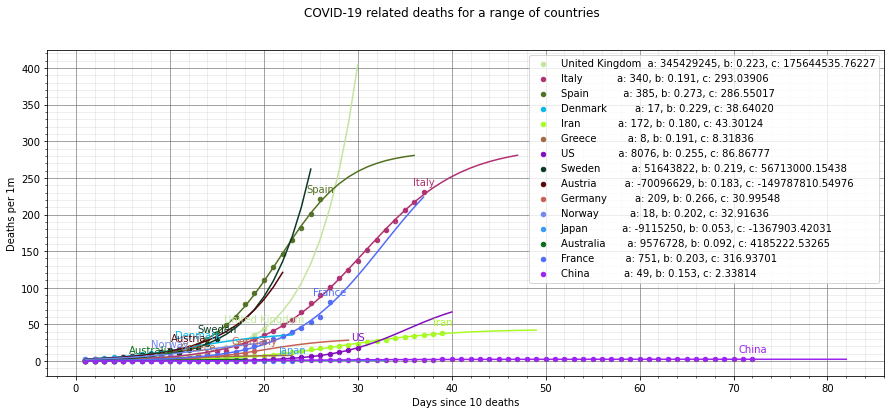

In [14]:
## Timeseries calculate  per 1M pop
def logistic_fit(x, a, b, c):
    """
    x is variable.
    a is shift along x axis
    b is steepness
    c is asymptote max
    """
    return c / (1 + a * np.exp(-b*x))

LogisticModel = Model(logistic_fit)

ts_df = pd.merge(ts_df.reset_index(), zone_df.set_index('zone')['population'], left_on='country', right_on='zone', how='left')
ts_df.set_index(['country', 'date'], inplace=True)
ts_df.sort_index(inplace=True)

one_mil = 10**6
LABELS = ('cases', 'deaths', 'recoveries')
MIN_REGRESSION_DATAPOINTS = 5
for label in LABELS:
    ts_df[label + "_per_1M"] = ts_df[label] * one_mil / ts_df['population']

label = 'deaths_per_1M'
regression_predict_length = 10
#countries = 'all'
countries = ['United Kingdom', 'Italy', 'Spain', 'Denmark', 'Iran', 'Greece', 'US', 'Sweden', 'Austria', 'Germany', 'Norway', 'Japan', 'Australia', 'France', 'China']

if label.startswith('cases'):
    n = 100
else:
    n = 10

fig, ax = plt.subplots(figsize=(15, 6))
# ax.set_yscale('log')

if countries == 'all':
    countries = ts_df.reset_index()['country'].unique()

countries_fit = []
for country in countries:
    col = np.random.rand(3,)
    x = find_date_of_nth_label(ts_df, country, n, label.strip('_per_1M'))
    if not x:
        continue

    #sub_df = ts_df[(ts_df['province_state'] == country) & (ts_df.index.is(country))]
    sub_df = ts_df.loc[country][ts_df.loc[country]['province_state'] == 'total']
    rel_df = sub_df[sub_df.index >= x]
    rel_df['rel_day'] = rel_df['day'] - rel_df['day'].iloc[0] + 1

    if len(rel_df) < MIN_REGRESSION_DATAPOINTS:
        continue

    # rel_df.plot.scatter(x='rel_day', y=label)

    model = LogisticModel
    params = model.make_params(c=1000, a=1000, b=0.3)
    result = model.fit(rel_df[label], params, x=rel_df['rel_day'])

    countries_fit.append({
        'zone': country,
        'fit_result': result,
        'fit_a': result.params['a'].value,
        'fit_b': result.params['b'].value,
        'fit_c': result.params['c'].value,
        'cases': rel_df.iloc[-1]['cases'],
        'deaths': rel_df.iloc[-1]['deaths'],
        'recoveries': rel_df.iloc[-1]['recoveries'],
        'cases_per_1M': rel_df.iloc[-1]['cases_per_1M'],
        'deaths_per_1M': rel_df.iloc[-1]['deaths_per_1M'],
        'recoveries_per_1M': rel_df.iloc[-1]['recoveries_per_1M'],
        'lat': rel_df.iloc[-1]['lat'],
        'long': rel_df.iloc[-1]['long'],
        'day': rel_df.iloc[-1]['day'],
        'rel_day': rel_df.iloc[-1]['rel_day'],
        'x': rel_df['rel_day'],
        'y': rel_df[label],
        'n': n,
        'col': col
    })

    
    axlbl = f'{country:<15} a: {result.params["a"].value:.0f}, b: {result.params["b"].value:.3f}, c: {result.params["c"].value:.5f}'

    subax = rel_df.plot.scatter(x='rel_day', y=label, color=[col], ax=ax, label=axlbl)
    q = rel_df['rel_day'].iloc[-1].astype(np.int64) + 1
    regression_range = np.float64(list(rel_df['rel_day'].astype(np.int64)) + list(range(q, q + regression_predict_length)))

    plt.plot(regression_range, result.eval(x=regression_range), color=col)

    x = rel_df.iloc[-1]['rel_day']
    y = rel_df.iloc[-1][label]

    ax.annotate(country, (x, y), color=col, textcoords='offset points', xytext=(0, 10), verticalalignment='center', horizontalalignment='center')
    #ax.annotate(label, xy=(1, y), xytext=(6, 0), color=line_handle.get_color(), xycoords = ax.get_yaxis_transform(), textcoords="offset points", size=14, va="center")
    
    print(result.params)

ax.set_ylabel(" ".join(label.split("_")).capitalize())
ax.set_xlabel(f"Days since {n} {label.strip('_per_1M')}")
fig.suptitle(f"COVID-19 related {label.strip('_per_1M')} for a range of countries")
plt.grid(b=True, which='major', color='#666666', linestyle='-', alpha=0.75)
plt.grid(b=True, axis='both', which='minor', color="#999999", linestyle='-', alpha=0.2)
plt.minorticks_on()
plt.legend()


In [15]:
new_df = pd.merge(zone_df, pd.DataFrame(countries_fit), on=['zone'], how='right')


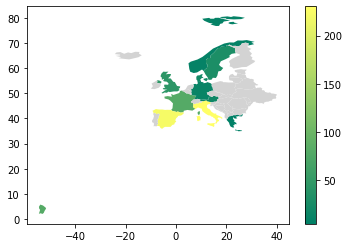

In [16]:

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

world.rename(columns={'name': 'zone'}, inplace=True)

a = world.merge(new_df, on='zone', how='outer')

a.query('continent == "Europe"').query('zone != "Russia"').plot(column='deaths_per_1M', legend=True, cmap='summer', missing_kwds={
    "color": 'lightgrey'
})

In [17]:
zone_df.query('zone == "France"')['population'].iloc[0]

66987244.0

In [18]:
pd.merge(ts_df.reset_index(), zone_df.set_index('zone')['population'], left_on='country', right_on='zone')

,country,date,province_state,lat,long,cases,deaths,recoveries,day,population_x,cases_per_1M,deaths_per_1M,recoveries_per_1M,population_y
0,Afghanistan,2020-01-22,Afghanistan,33.0,65.0,0,0,0,0.0,37172386.0,0.000000,0.000000,0.0,37172386.0
1,Afghanistan,2020-01-22,total,33.0,65.0,0,0,0,0.0,37172386.0,0.000000,0.000000,0.0,37172386.0
2,Afghanistan,2020-01-23,Afghanistan,33.0,65.0,0,0,0,1.0,37172386.0,0.000000,0.000000,0.0,37172386.0
3,Afghanistan,2020-01-23,total,33.0,65.0,0,0,0,1.0,37172386.0,0.000000,0.000000,0.0,37172386.0
4,Afghanistan,2020-01-24,Afghanistan,33.0,65.0,0,0,0,2.0,37172386.0,0.000000,0.000000,0.0,37172386.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26995,Zimbabwe,2020-03-31,total,-20.0,30.0,8,1,0,69.0,14439018.0,0.554054,0.069257,0.0,14439018.0
26996,Zimbabwe,2020-04-01,Zimbabwe,-20.0,30.0,8,1,0,70.0,14439018.0,0.554054,0.069257,0.0,14439018.0
26997,Zimbabwe,2020-04-01,total,-20.0,30.0,8,1,0,70.0,14439018.0,0.554054,0.069257,0.0,14439018.0
26998,Zimbabwe,2020-04-02,Zimbabwe,-20.0,30.0,9,1,0,71.0,14439018.0,0.623311,0.069257,0.0,14439018.0


In [19]:
pd.merge(x_, x_[ts_df.index.to_flat_index()]

SyntaxError: unexpected EOF while parsing (<ipython-input-19-a912e87872c9>, line 1)

In [20]:
ts_df.index.get_level_values(0)
#ts_df.index.to_flat_index()

Index(['Afghanistan', 'Afghanistan', 'Afghanistan', 'Afghanistan',
       'Afghanistan', 'Afghanistan', 'Afghanistan', 'Afghanistan',
       'Afghanistan', 'Afghanistan',
       ...
       'Zimbabwe', 'Zimbabwe', 'Zimbabwe', 'Zimbabwe', 'Zimbabwe', 'Zimbabwe',
       'Zimbabwe', 'Zimbabwe', 'Zimbabwe', 'Zimbabwe'],
      dtype='object', name='country', length=30024)